In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

In [2]:
from src.nbody.main import NBodySimulation
import src.nbody.plot_utils as pu

In [3]:
ic_file = "./ics/sun.hdf5"
# ic_file = "./ics/DM_halo.hdf5"

In [4]:
with h5.File(ic_file, "r") as hf:
    print(list(hf["Bodies"]))

['Masses', 'Positions', 'Velocities']


In [5]:
path_ics = ic_file
output_folder = "./outputs/"

In [6]:
# # N = 2e4  # Number of particles
# # N = int(N)

# # R_s = 20.0  # Scale radius of the NFW profile (kpc)
# # R_d = R_s / 4.5  # Scale radius of the disk (kpc)
# rho_0 = 5932371.0  # Central density of the NFW profile (Msun/kpc^3)
# # pos_std = 1  # Noise std for the positions
# vel_std = 1  # Noise std for the velocities
# total_mass = 5e10  # Total mass of the galaxy (Msun)
G = 4.30091e-6

In [7]:
path_output = output_folder + 'output.hdf5'

e = 0.01
T = 0.7
dt = 5e-4
num_snapshots = 600

Sim = NBodySimulation(path_ics, path_output)
# Sim.R_s = R_s
# Sim.rho_0 = rho_0

Sim.set_time(T, dt, snapshots=num_snapshots)
Sim.set_time_NFW_off(0.4)  # Turn off  the NFW profile at approx t=1.25

# Sim.set_integrator("RK4")
Sim.set_integrator("Euler")
# Sim.set_integrator("Symplectic")

Sim.estimate_runtime(3)  # We get a runtime estimation for 3 snapshots
Sim.run_simulation(e=e, G=G)

Estimated time: 00h 00m 07s
Mean time per step: 5.56e-03 s
99.93%
Elapsed time: 0.71 s


In [8]:
# path_output = sim_folder + 'output.hdf5'

# e = 0.01
# T = 2.5
# dt = 5e-4
# num_snapshots = 600

# Sim = NBodySimulation(path_ics, path_output)
# Sim.R_s = R_s
# Sim.rho_0 = rho_0

# Sim.set_time(T, dt, snapshots=num_snapshots)
# Sim.set_time_NFW_off(1.25)  # Turn off the NFW profile at approx t=1.25
# Sim.estimate_runtime(3)  # We get a runtime estimation for 3 snapshotsa

In [9]:
# Sim.run_simulation(e=e)

In [10]:
# pu.make_frames(path_output, 
#                marker_size=0.1,
#                   )

In [11]:
# import cv2
# import os

# def create_video_from_frames(frame_folder, output_video_path, frame_rate=30, resolution=None):
#     # Get a list of all files in the folder
#     files = [f for f in os.listdir(frame_folder) if os.path.isfile(os.path.join(frame_folder, f))]
#     # Sort files to ensure the correct order
#     files.sort()
    
#     # Read the first image to get the dimensions
#     first_frame = cv2.imread(os.path.join(frame_folder, files[0]))
#     height, width, layers = first_frame.shape
    
#     if resolution:
#         width, height = resolution

#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     video = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))

#     for file in files:
#         frame_path = os.path.join(frame_folder, file)
#         frame = cv2.imread(frame_path)

#         if resolution:
#             frame = cv2.resize(frame, (width, height))

#         video.write(frame)

#     video.release()
#     print(f"Video saved to {output_video_path}")



In [12]:
# # Example usage
# frame_folder = 'outputs/frames/'
# output_video_path = 'outputs/output_video.mp4'
# create_video_from_frames(frame_folder, output_video_path, frame_rate=30, resolution=(400, 400))

In [13]:
POS_R, VEL_R, MASS, TIME = Sim.get_output()

# POS_R = POS_R.reshape(600,3)
# VEL_R = VEL_R.reshape(600,3)

In [14]:
VEL_R.shape

(600, 1, 3)

In [15]:
# fig, ax = plt.subplots()
# ax.plot(POS_R[:,0], POS_R[:,1])
# ax.scatter(0, 0, facecolors='none', edgecolors='black', s=80)
# ax.scatter(0, 0, marker="*", edgecolors='black', s=35)
# ax.set_aspect("equal")

In [16]:
# r = np.sqrt(POS_R[:,0]**2 + POS_R[:,1]**2)
# fig, ax = plt.subplots()
# ax.plot(TIME, r)

In [17]:
# r = np.sqrt(VEL_R[:,0]**2 + VEL_R[:,1]**2)
# fig, ax = plt.subplots()
# ax.plot(TIME, r)

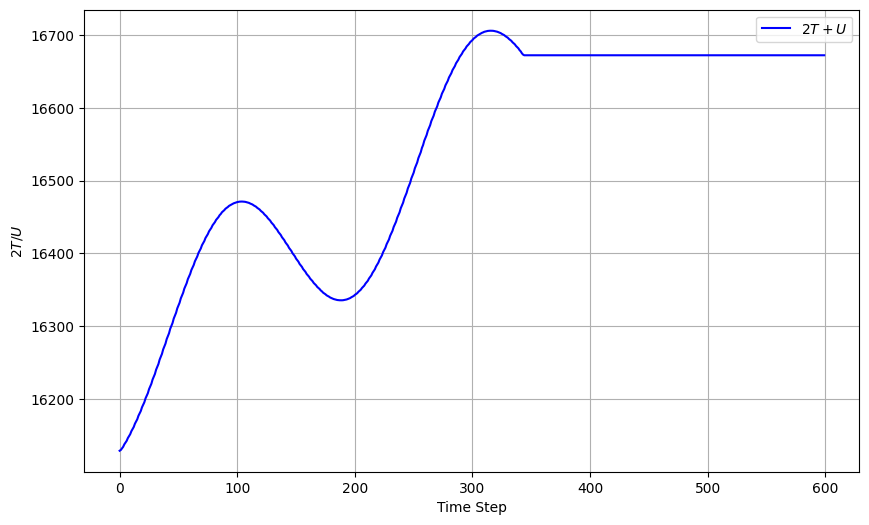

In [18]:
from numba import njit, prange

# Conversion factors
# kpc_to_m = np.float64(3.0857e19)  # 1 kpc = 3.0857e19 meters
# kmps_to_mps = 1e3     # 1 km/s = 1e3 meters/second
# Msun_to_kg = np.float64(1.9885e30)  # 1 Solar Mass = 1.9885e30 kg

m=MASS[0] #* Msun_to_kg

G = 4.302e-6

# Convert G from original units to SI units
# G_SI = np.float64(6.67430e-11)  # m^3 kg^-1 s^-2

Gm2 = np.float64(G * m**2)  # Precompute G * m^2

# POS_R = POS_R * kpc_to_m
# VEL_R = VEL_R * kmps_to_mps

# Calculate the kinetic energy T(t)
vel_squared = np.sum(VEL_R**2, axis=2)  # v_i^2 for each particle
T_t = 0.5 * m * np.sum(vel_squared, axis=1)  # Sum over all particles


@njit(parallel=True, fastmath=True, cache=False)
def calculate_potential_energy(positions, Gm2):
    num_timesteps = positions.shape[0]
    num_particles = positions.shape[1]
    U_t = np.zeros(num_timesteps)
    
    for t in prange(num_timesteps):
        U = 0.0
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                dx = positions[t, i, 0] - positions[t, j, 0]
                dy = positions[t, i, 1] - positions[t, j, 1]
                dz = positions[t, i, 2] - positions[t, j, 2]
                r_ij = np.sqrt(dx * dx + dy * dy + dz * dz)  # Manually compute distance
                if r_ij > 0:  # Avoid division by zero
                    U -= Gm2 / r_ij
        U_t[t] = U
        
    return U_t

# Potential energy calculation using Numba
U_t = calculate_potential_energy(POS_R, Gm2)

# Calculate the virial quantity 2T + U
virial_quantity = (2 * T_t) + np.abs(U_t)

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(virial_quantity, label=r"$2T + U$", color='b')
# plt.axhline(1, color='r', linestyle='--', label="Equilibrium Line")
plt.xlabel("Time Step")
plt.ylabel(r"$2T / U$")
# plt.title("Virial Theorem Verification")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
POS_R[-1,:,:].shape

(1, 3)

In [20]:
POS_R = POS_R[-1,:,:]

VEL_R = VEL_R[-1,:,:]


In [21]:
counts, rbins = np.histogram(np.sqrt(x*x + y*y), bins=100)
c, r = np.histogram(np.sqrt(x*x + y*y), bins=100)

NameError: name 'x' is not defined

In [ ]:
plt.plot(0.5*(r[1:]+r[:-1]),c)
# plt.xscale("log")
plt.xlim(0,15)

In [ ]:
# Calculate radial distances from the center (assuming center at origin)
r = np.sqrt(np.sum(POS_R**2, axis=1))  # shape (10000,)

# Calculate circular (tangential) velocities
v_circ = np.sqrt(np.sum(VEL_R**2, axis=1))  # shape (10000,)

# Bin the radial distances
radial_bins = np.linspace(0, np.max(r), 100)  # 50 bins from 0 to max radial distance
radial_bin_centers = 0.5 * (radial_bins[:-1] + radial_bins[1:])
v_circ_avg = np.zeros_like(radial_bin_centers)

# Calculate average circular velocity in each radial bin
for i in range(len(radial_bin_centers)):
    in_bin = (r >= radial_bins[i]) & (r < radial_bins[i+1])
    v_circ_avg[i] = np.mean(v_circ[in_bin])

# Plot the rotation curve
plt.figure(figsize=(10, 6))
plt.plot(radial_bin_centers, v_circ_avg, 'o', color='blue')  # converting to kpc and km/s for plot
plt.xlim(0,50)
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Circular Velocity (km/s)')
plt.title('Rotation Curve')
plt.grid(True)
plt.show()